In [1]:
import sys
import os
import itertools 
module_path = os.path.abspath(os.path.join('../')) 
sys.path.insert(0, module_path)


import pandas as pd
from pathlib import Path
import json
from datetime import datetime
import seaborn as sns

import katspace
import katspace.core
import katspace.data
import katspace.plot


import importlib
for mod in ["katspace.core", "katspace.data", "katspace.plot"]:
    importlib.reload(sys.modules[mod])

from katspace.core import DATA_DIR, DRIVE_DIR, SPACE_TYPES, RESULTS_DIR
from katspace.data import chunker
from katspace.plot import hist_heatmap as plot_hist_heatmap

import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import numpy as np
import math


RESULTS_DIR_NON_FIC = Path(RESULTS_DIR, "predict-286-non-fic")

Configuration file /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/katspace_config.json not found in /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/notebooks


In [2]:
def sum_results(labels):
  counter = Counter(labels)
  return counter

def results_from_json_old(filename, results_dir = RESULTS_DIR_NON_FIC):
    json_file_path = Path(results_dir, Path(filename).stem + '-result.json')

    if json_file_path.exists():
        with open(json_file_path, 'r', encoding="utf-8") as f:
            json_results = json.load(f)
        return json_results
    else:
        return None

#copied to data.py
def results_from_json(filenames, results_dir = RESULTS_DIR_NON_FIC): 

  if isinstance(filenames, str):
    filename = filenames
    json_file_path = Path(results_dir, Path(filename).stem + '-result.json')

    if json_file_path.exists():
        with open(json_file_path, 'r', encoding="utf-8") as f:
            json_results = json.load(f)
        return json_results
    else:
        return None
  elif isinstance(filenames, list):
    return {filename : results_from_json(filename) for filename in filenames}

def results_into_df(df  : pd.DataFrame, results_dir = None) -> pd.DataFrame :
  
  #filenames = df["Filename"]
  corpus_sel = df

  for space_type in SPACE_TYPES:
    corpus_sel.loc[:,space_type] = [0]*corpus_sel.shape[0]

  for index, row in tqdm(corpus_sel.iterrows()):
    filename = row["filename"]
    results = results_from_json(filename, results_dir = results_dir) 
    if results is not None:
      #print(results[0])
      labels = [result["label"] for result in results]
      result = sum_results(labels)
      for space_type in SPACE_TYPES:
        corpus_sel.loc[index, space_type] = result[space_type]
  return corpus_sel

def prepare_plot_from_json(corpus_sel : pd.DataFrame):
  grouped_data = corpus_sel.groupby("year")["filename"]
  years = []
  space_types_dict = {space_type : [] for space_type in SPACE_TYPES}
  space_types_dict["total"] = []
  space_types_dict["all_space"] = []

  for year, seq in grouped_data:
      year_fn = seq.unique()
      #print(year)
      results = []
      for filename in year_fn:
          json_result = results_from_json(filename)
          if json_result is not None:
              results += json_result
      labels = [result["label"] for result in results]
      space_labels = [result["label"] for result in results if result["label"] != 'no_space']
      year_sum = sum_results(labels)
      space_year_sum = sum_results(space_labels)
      #print(year_sum)
      years.append(year)
      for space_type in SPACE_TYPES:
          space_types_dict[space_type].append(year_sum[space_type])

      space_types_dict["total"].append(year_sum.total())
      space_types_dict["all_space"].append(space_year_sum.total())
  return years, space_types_dict

def prepare_plot_from_df(corpus_sel : pd.DataFrame):
  corpus_sel = corpus_sel[corpus_sel["total"] > 0]
  cols = ["year"] + list(SPACE_TYPES)
  summed_data = corpus_sel[cols].groupby("year").sum().loc[:,SPACE_TYPES]

  space_types_dict = {space_type : [] for space_type in SPACE_TYPES}
  space_types_dict["total"] = []
  space_types_dict["all_space"] = []

  summed_data["total"] = sum([summed_data[space_type] for space_type in SPACE_TYPES])
  summed_data["all_space"]  = sum([summed_data[space_type] for space_type in SPACE_TYPES if space_type != "no_space"])

  years = summed_data.index.astype(float)
  for space_type in summed_data:
    space_types_dict[space_type] = summed_data[space_type]

  return years, space_types_dict

def prepare_plot_from_df_w_sums(corpus_sel : pd.DataFrame, smooth_to_next_decade = False):
  cols = ["year"] + list(SPACE_TYPES) + ["all_space", "total"]
  if smooth_to_next_decade:
    
    def round_to_decade(y):
      return int(10 * math.floor(y / 10))

    corpus_sel["year"] = corpus_sel["year"].apply(round_to_decade)

  summed_data = corpus_sel[cols].groupby("year").sum()

  space_types_dict = {space_type :  summed_data[space_type] for space_type in list(SPACE_TYPES) + ["all_space", "total"]}

  years = summed_data.index.astype(float)
     
  return years, space_types_dict


def plot_narrative_time(results, chunksize = 50, space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space"),
                        total = False, sum_sel = ("perceived_space", "action_space", "visual_space", "descriptive_space")):
  def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]


  def total_sum(counter, sum_sel):
    num = [counter[space_type] for space_type in sum_sel]
    return sum(num)

  labels = [result["label"] for result in results]
  chunks = chunker(labels, chunksize)
  num_chunks = len(chunks)
  


  counters = [Counter(chunk) for chunk in chunks]
  # change order of indexing to have space type as outermost index
  count_dict = {space_type : [counter[space_type] for counter in counters] for space_type in space_types}
  count_dict["all_space"] = [total_sum(counter, sum_sel) for counter in counters]

  fig, ax = plt.subplots()
  x = [chunk[0] for chunk in chunker(range(len(labels)), chunksize)]

  for space_type in SPACE_TYPES:
    y = np.array(count_dict[space_type]) / np.array([chunksize]*num_chunks)

    label = space_type

    ax.plot(x, y, label = label)

  if total:
    y = np.array(count_dict["all_space"]) / np.array([chunksize]*num_chunks)

    label = "all_space"
    ax.plot(x, y, label = label)

  ax.legend()
  ax.set_xlabel("Sentences")
  ax.set_ylabel("% Types of setting")
  plt.show()

def plot_history(years, space_types_dict, normalize = True, total_space = False, cumul = False, plot_no_space = False, smooth_to_next_decade = False):
  fig, ax = plt.subplots(figsize=(10, 6))
  
  y_dict = {}
  types_for_plot = list(SPACE_TYPES)

  if total_space:
     types_for_plot = types_for_plot + ["all_space"]

  for space_type in types_for_plot:
    if (not plot_no_space) and space_type == 'no_space':
      continue
    if normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type]) / np.array(space_types_dict["total"])
    elif not normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type])

  if smooth_to_next_decade:
     delta_year = 10
  else:
     delta_year = 15
  ticks = [ year for year in years if year%delta_year==0]
  labels = map(str,map(round,ticks))

  for space_type in y_dict.keys():
    label = space_type
    ax.plot(years, y_dict[space_type], label=label)

  ax.legend()
  ax.set_xlabel("Year")
  ax.set_ylabel("Frequency")
  ax.set_xticks(ticks, labels=labels, rotation=90)

  return fig, ax



def plot_preprocess(results, num_chunks=20, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space"), results_format = "parquet"):
    #ignore files without results
    results = {filename: result for filename, result  in results.items() if result != None}

    #ignore files with fewer than num_chunks sentences
    results = {filename: result for filename, result  in results.items() if len(result) >= num_chunks}

    print(f"Ignoring {len([filename for filename, result  in results.items() if len(result) < num_chunks])} files because they have too few sents")

    if results_format != "parquet":
      labels = {filename: [result["label"] for result in results[filename]] for filename in results.keys()}
    else:
      labels = results

    chunked_labels = {filename: chunker(labels[filename], num_chunks=num_chunks) for filename in labels.keys()}
    chunk_sizes = {filename: [len(chunk) for chunk in chunked_labels[filename]] for filename in labels.keys()}
    chunk_size_zero = [filename for filename in labels.keys() if chunk_sizes[filename] == 0]
    if len(chunk_size_zero) > 0:
      print(f"The followowing files have chunks of size 0: \n {chunk_size_zero}")

    counters = {filename: [Counter(label_chunk) for label_chunk in chunked_labels[filename]] for filename in chunked_labels.keys()}

    def total_sum(counter, sum_sel):
        num = [counter[space_type] for space_type in sum_sel]
        return sum(num)

    # change order of indexing to have space type as outermost index
    count_dict = {space_type: {filename: [counter[space_type] for counter in counters[filename]] for filename in counters.keys()} for space_type in SPACE_TYPES}

    count_dict["all_space"] = {}
    for filename in counters.keys():
      count_dict["all_space"][filename] = [total_sum(counter, sum_sel) for counter in counters[filename]]

    return count_dict, chunk_sizes

def plot_hist(count_dict, chunk_sizes, title = "", fig = None, ax = None, bins = [20, 20], **kwargs):

    num_chunks = bins[0]

    x,y = plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = num_chunks, debug_msg = title)
    ax.set_title(title)
    ax.set_xlabel("Narrative section")
    ax.set_ylabel("Frequency")
    ax.hist2d(x, y, bins = bins, **kwargs)

def plot_violin(count_dict, chunk_sizes, num_chunks, title = "", fig = None, ax = None, **kwargs):
    
    data = [[count_dict[filename][col] / chunk_sizes[filename][col] for filename in count_dict.keys()] for col in range(0, num_chunks)]
    pos = range(0, num_chunks)
    ax.violinplot(data, pos, points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
    ax.set_title(title)

def plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = 20, debug_msg = ""):

    y = []
    x = []

    for filename in count_dict.keys():
        for c, size in enumerate(chunk_sizes[filename]):
          if size == 0:
            print(f"chunk nr {c} has size zero: {filename}")
            #zero_chunks.append((filename, c))
        norm_counts_np = np.array(count_dict[filename]) / np.array(chunk_sizes[filename])
        y += list(norm_counts_np)
        x += range(1, num_chunks + 1)
        if len(x) != len(y):
          print(f"x and y have different lengths: {filename}, {debug_msg} \n ++++++ x: {x}, \n ++++++ y: {y}")
          break
    return x,y
    
def plot_narrative_time_stats(results, num_chunks=20, plot_type = "histogram", space_types=("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space"),
                                total=False, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space")):

    count_dict, chunk_sizes = plot_preprocess(results, num_chunks, sum_sel)
    vert_num_chunks = 20

    if total == True:
      space_types = list(space_types) + ["all_space"]

    if plot_type == "histogram":
      color = {"perceived_space": "Blues",
                "action_space": "Greens",
                "visual_space": "Reds",
                "descriptive_space": "GnBu",
                "no_space": "Greys",
                "all_space": 'Purples'
                }


      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(3, len(space_types) * 3),
                        layout="constrained") 

      for i, space_type in enumerate(space_types):
        plot_hist(count_dict[space_type], chunk_sizes, title = space_type, fig = fig, ax = axs[i], bins = [num_chunks, vert_num_chunks], cmap = color[space_type])

    elif plot_type == "violin":     
      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(10, len(space_types) * 6),
                        layout="constrained")
     # pos = range(1, num_chunks + 1)
      for i, space_type in enumerate(space_types):
        plot_violin(count_dict[space_type], chunk_sizes, num_chunks, title = space_type, fig = fig, ax = axs[i])
    
    elif plot_type == "contour":
      pass
    plt.show()

In [ ]:
non_fic_df = pd.read_excel(Path(DATA_DIR, "20240816_non_fic_master.xlsx"), index_col = 0)
non_fic_df

In [ ]:
filenames = non_fic_df["filename"]
filenames = list(filenames)
filenames

In [14]:
results = results_from_json(filenames)

In [21]:
count_dict, chunk_sizes = plot_preprocess(results, results_format = "json")

Ignoring 0 files because they have too few sents


In [ ]:
sel = (non_fic_df["year"] > 1770) & (non_fic_df["year"] < 1950)
plot_hist_heatmap(non_fic_df[sel])

In [8]:
sel_genre = (non_fic_df["genre_2"] != "Reiseberichte, Reiseerzählungen")

In [14]:
non_fic_df[sel_genre]

,author_last,author_first,title,year,firstpub,genre_1,genre_2,genre_3,filename,title_y,perceived_space,action_space,visual_space,descriptive_space,no_space,total,all_space
0,Adlersfeld-Ballestrem,Eufemia von,Aus der Rumpelkammer der Weltgeschichte,1895,NaN,Sachbuch,Geschichte,"Kulturgeschichte, einzelne Themen",Eufemia_von_Adlersfeld-Ballestrem_-_Aus_der_Ru...,Aus der Rumpelkammer der Weltgeschichte,50,143,5,12,1595,1805,210
2,Autoren,Unbekannte,Geschichte einer Somnambüle in Weilheim an der...,1924,NaN,Sachbuch,Religion,Spiritualität,Unbekannter_Verfasser_-_Geschichte_einer_Somna...,Geschichte einer Somnambüle in Weilheim an der...,236,274,40,73,2464,3087,623
3,Humboldt,Alexander von,Über das Universum,1828,NaN,Sachbuch,Natur,Naturwissenschaften,_-_Über_das_Universum.txt,Über das Universum. Anonyme Mitschrift der Kos...,382,41,12,79,1171,1685,514
4,Autor,Unbekannter,Briefe eines Soldaten,1917,1917,Sachbuch,Geschichte,Neuzeit bis 1918,Unbekannter_Verfasser_-_Briefe_eines_Soldaten.txt,Briefe eines Soldaten,376,117,20,21,1634,2168,534
6,Autoren,Verschiedene,Die Zerstörung Magdeburgs 1631,1922,NaN,Sachbuch,Geschichte,"Kulturgeschichte, einzelne Themen",Verschiedene_Autore_-_Die_Zerstörung_Magdeburg...,Die Zerstörung Magdeburgs 1631,35,458,7,17,403,920,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Zimmer,Heinrich,Maya der indische Mythos,1936,1936,Sachbuch,Religion,Weitere Religionen,Heinrich_Zimmer_-_Maya_der_indische_Mythos.txt,Maya der indische Mythos,698,663,44,25,5665,7095,1430
823,Zimmer,Heinrich,Yoga und Buddhismus,1932,1925 - 1932,Sachbuch,Religion,Weitere Religionen,Heinrich_Zimmer_-_Yoga_und_Buddhismus.txt,Yoga und Buddhismus,195,36,3,11,2554,2799,245
824,Zimmermann,Wilhelm,Geschichte des großen Bauernkriegs. Erster Band,1843,1843,Sachbuch,Geschichte,Neuzeit bis 1918,Wilhelm_Zimmermann_-_Geschichte_des_großen_Bau...,Geschichte des großen Bauernkriegs. Erster Band,249,1545,23,235,6585,8637,2052
825,Zimmermann,Wilhelm,Geschichte des großen Bauernkriegs. Zweiter Band,1843,1843,Sachbuch,Geschichte,Neuzeit bis 1918,Wilhelm_Zimmermann_-_Geschichte_des_großen_Bau...,Geschichte des großen Bauernkriegs. Zweiter Band,386,2824,60,306,6935,10511,3576


/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_45344/348378196.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_df = katspace.plot.calculate_ratios(gutenberg_df[sel_year][sel_genre])


Text(0.5, 0, 'Year')

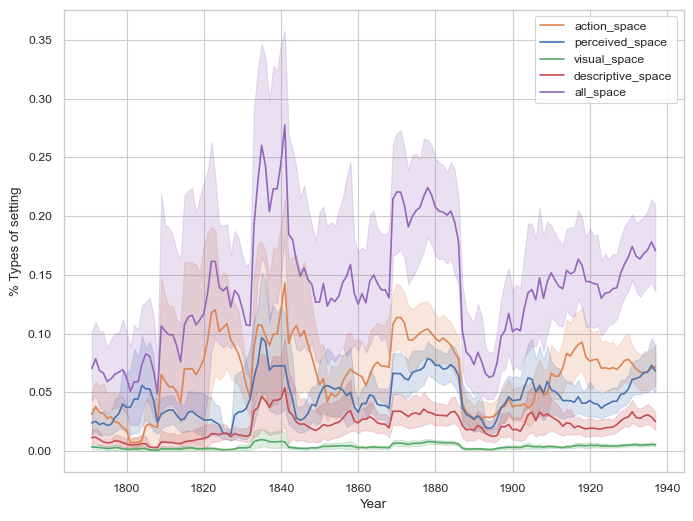

In [6]:
sel_year = (non_fic_df["year"] > 1780) & (non_fic_df["year"] < 1940)
sel_genre = (non_fic_df["genre_2"] != "Reiseberichte, Reiseerzählungen")
plot_df = katspace.plot.calculate_ratios(non_fic_df[sel_year][sel_genre])
smooth_df = katspace.plot.smooth_df(plot_df[["action_space_rt", "perceived_space_rt", "visual_space_rt", "descriptive_space_rt", "all_space_rt"]]
                                    )
sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
lines = sns.lineplot(smooth_df, palette=["#dd8452", "#4c72b0", "#55a868", "#c44e52", "#9467bd"], dashes=False)
handles, labels = lines.get_legend_handles_labels()
custom_labels = ['action_space', 'perceived_space', 'visual_space', 'descriptive_space', 'all_space']
    
   
plt.legend(handles=handles[:5], labels=custom_labels)
plt.ylabel("% Types of setting")
plt.xlabel("Year")


# Descriptives

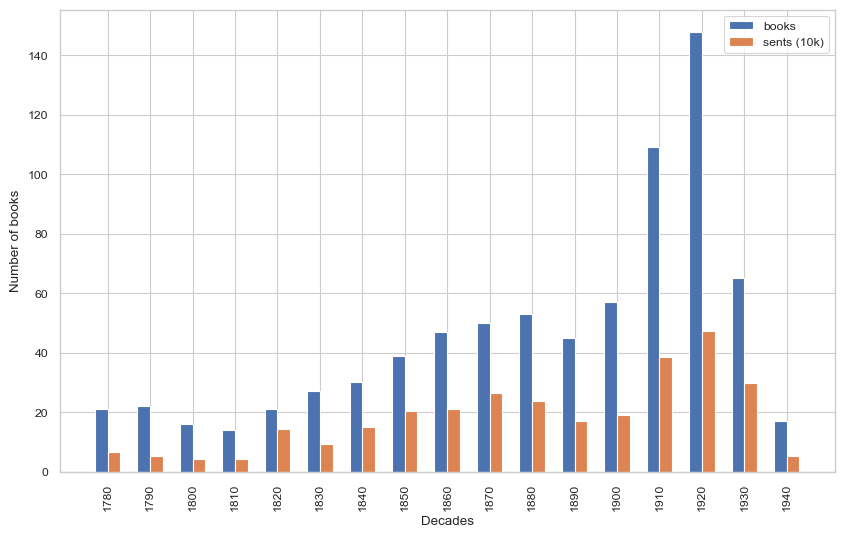

In [12]:
sns.set_theme("paper")
sns.set_style("whitegrid")

df = non_fic_df.loc[:,["year", "total"]]
sel = (non_fic_df["year"] > 1780) & (non_fic_df["year"] < 1950)
df = df[sel]
df.loc[:,'books'] = 1 

def round_to_decade(y):
    return int(10 * math.floor(y / 10))

df["year"] = df["year"].apply(round_to_decade)

df_sums = df.groupby('year').sum()
df_sums["total"] = df_sums["total"] / 10000

df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)
years = df_sums.index.values

x = [xpos for xpos in range(len(years))]


fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3


ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
ax.set_xlabel("Decades")
ax.set_ylabel("Number of books")
ax.set_xticks(x, labels=years, rotation = 90)


_ = ax.legend()

In [16]:
genre_dict = {'Geschichte' : "history", 
              'Natur' : "nature", 
              'Philosophie' : "philosophy", 
              'Praktisches' : "self-help", 
              'Reiseberichte, Reiseerzählungen' : "travelogues", 
              'Religion' : "religion"}

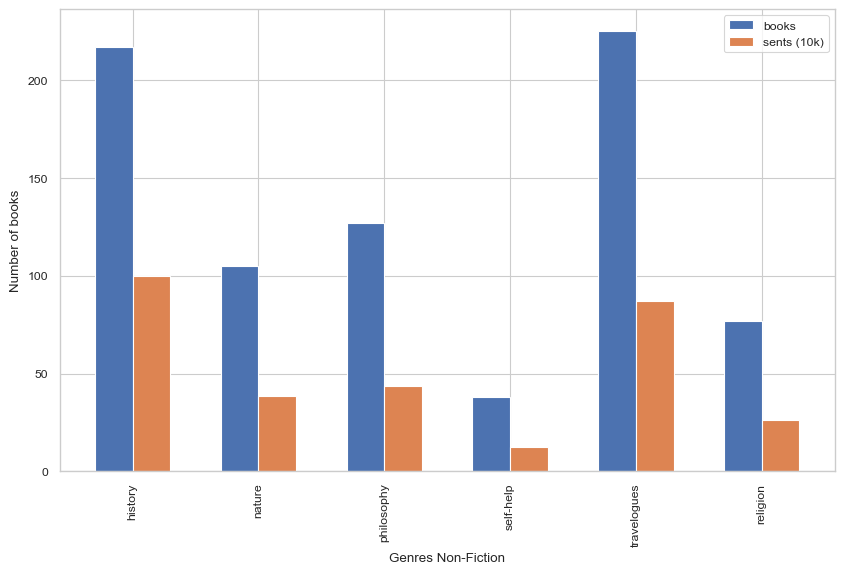

In [17]:
df = non_fic_df.loc[:,["year", "genre_2", "total"]]
sel = (non_fic_df["year"] > 1770) & (non_fic_df["year"] < 1950)
df = df[sel][["genre_2", "total"]]
df.loc[:,'books'] = 1 

df_sums = df.groupby('genre_2').sum()
df_sums["total"] = df_sums["total"] / 10000
df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)

#df_sums = df_sums.drop("Romane, Novellen und Erzählungen", axis = 0)

df_sums.index = df_sums.index.map(genre_dict)

x_labels = df_sums.index.values

x = [xpos for xpos in range(len(x_labels))]

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
ax.set_xlabel("Genres Non-Fiction")
ax.set_ylabel("Number of books")
ax.set_xticks(x, labels= x_labels, rotation = 90)

_ = ax.legend()

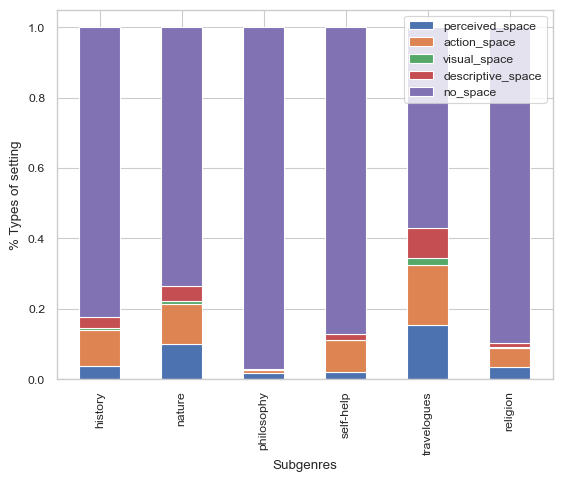

In [18]:
def genre_stackplot(gutenberg_df): 
    cols = ["genre_2"] + list(SPACE_TYPES) + ["total"]
    genre_df = gutenberg_df[cols].groupby("genre_2").sum()
    genre_df.index.names = ["genre"]

    genres = genre_df.index.values
    genres = [genre_dict[genre] for genre in genres]
    space_counts = {
        space_type : genre_df[space_type]  for space_type in SPACE_TYPES            
    }

    norm_space_counts = {
        space_type : genre_df[space_type] / genre_df["total"] for space_type in SPACE_TYPES 
    }
    width = 0.5

    fig, ax = plt.subplots()

    bottom = np.zeros(6)

    for space_type, space_count in norm_space_counts.items():

        #genre = genre_dict[genre]
        p = ax.bar(genres, space_count, width, label=space_type, bottom=bottom)
        bottom += space_count

    #ax.set_title("Number of penguins with above average body mass")
    ax.legend(loc="upper right")
    ax.set_xlabel("Subgenres")
    ax.set_ylabel("% Types of setting")
    
    plt.xticks(rotation=90)
    

    plt.show()

genre_stackplot(non_fic_df)

In [8]:
non_fic_small = non_fic_df.drop(["title", "title_y", "firstpub", "genre_1", "genre_2", "genre_3", "filename"], axis=1)
sel = (non_fic_small["year"] > 1780) & (non_fic_small["year"] < 1940)
non_fic_small[sel]

,author_last,author_first,year,perceived_space,action_space,visual_space,descriptive_space,no_space,total,all_space
0,Adlersfeld-Ballestrem,Eufemia von,1895,50,143,5,12,1595,1805,210
1,Ahlers,Jacob,1911,81,149,17,139,339,725,386
2,Autoren,Unbekannte,1924,236,274,40,73,2464,3087,623
3,Humboldt,Alexander von,1828,382,41,12,79,1171,1685,514
4,Autor,Unbekannter,1917,376,117,20,21,1634,2168,534
...,...,...,...,...,...,...,...,...,...,...
824,Zimmermann,Wilhelm,1843,249,1545,23,235,6585,8637,2052
825,Zimmermann,Wilhelm,1843,386,2824,60,306,6935,10511,3576
826,Zobeltitz,Martha von,1923,3,357,0,20,1114,1494,380
827,Zweig,Stefan,1928,95,18,1,30,204,348,144


In [9]:
nf_group = non_fic_small[sel].groupby(["author_last", "author_first"])
nf_authors = nf_group.agg(
    min_year=pd.NamedAgg(column="year", aggfunc="min"),
    max_year=pd.NamedAgg(column="year", aggfunc="max"),
    perveived_space=pd.NamedAgg(column="perceived_space", aggfunc="sum"), 
    action_space=pd.NamedAgg(column="action_space", aggfunc="sum"),
    visual_space=pd.NamedAgg(column="visual_space", aggfunc="sum"),
    descriptive_space=pd.NamedAgg(column="descriptive_space", aggfunc="sum"),
    no_space=pd.NamedAgg(column="no_space", aggfunc="sum"),
    all_space=pd.NamedAgg(column="all_space", aggfunc="sum"),
    total=pd.NamedAgg(column="total", aggfunc="sum"))
nf_authors["num_books"] = nf_group.size()
nf_authors

,,min_year,max_year,perveived_space,action_space,visual_space,descriptive_space,no_space,all_space,total,num_books
author_last,author_first,,,,,,,,,,
Adlersfeld-Ballestrem,Eufemia von,1895,1895,50,143,5,12,1595,210,1805,1
Ahlers,Jacob,1911,1911,81,149,17,139,339,386,725,1
Andreas-Salomé,Lou,1910,1910,13,1,0,0,402,14,416,1
Aram,Kurt,1912,1927,442,1400,90,420,7838,2352,10190,3
Archenholz,Johann Wilhelm von,1913,1913,58,477,10,42,858,587,1445,1
...,...,...,...,...,...,...,...,...,...,...,...
Zimmer,Heinrich,1932,1938,1090,788,51,61,10562,1990,12552,3
Zimmermann,Wilhelm,1843,1843,635,4369,83,541,13520,5628,19148,2
Zobeltitz,Martha von,1923,1923,3,357,0,20,1114,380,1494,1


# Tukey test

In [14]:
from scipy.stats import tukey_hsd

def prep_tukey_kramer(gutenberg_df): 
    cols = ["genre_2"] + list(SPACE_TYPES) + ["total"]
    genre_df = gutenberg_df[cols].groupby("genre_2").sum()
    genre_df.index.names = ["genre"]

    genres = genre_df.index.values
    dir = { space_type: {} for space_type in SPACE_TYPES} 
    for space_type, genre in itertools.product(SPACE_TYPES, genres):
        positive = genre_df.loc[genre, space_type] 
        negative = genre_df.loc[genre, "total"] - positive
        group_samples = ([1] * positive) + ([0] * negative)
        genre_e = genre_dict[genre]
        dir[space_type][genre_e] = group_samples
    return dir 

def tukey_kramer(dir, space_types):
    res_dict = {}
    for space_type in space_types:
        groups = list(dir[space_type].values())
        res = tukey_hsd(*groups)
        print("\n\n\n")
        print(space_type)
        print(res)
        res_dict[space_type] = res
    return res_dict

dir = prep_tukey_kramer(non_fic_df)

In [15]:
res = tukey_kramer(dir, SPACE_TYPES)
genres = dir["action_space"].keys()





perceived_space
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.061     0.000    -0.063    -0.060
 (0 - 2)      0.019     0.000     0.018     0.021
 (0 - 3)      0.019     0.000     0.016     0.021
 (0 - 4)     -0.116     0.000    -0.118    -0.115
 (0 - 5)      0.002     0.000     0.001     0.004
 (1 - 0)      0.061     0.000     0.060     0.063
 (1 - 2)      0.081     0.000     0.079     0.082
 (1 - 3)      0.080     0.000     0.077     0.082
 (1 - 4)     -0.055     0.000    -0.057    -0.054
 (1 - 5)      0.063     0.000     0.062     0.065
 (2 - 0)     -0.019     0.000    -0.021    -0.018
 (2 - 1)     -0.081     0.000    -0.082    -0.079
 (2 - 3)     -0.001     0.934    -0.003     0.002
 (2 - 4)     -0.136     0.000    -0.137    -0.134
 (2 - 5)     -0.017     0.000    -0.019    -0.015
 (3 - 0)     -0.019     0.000    -0.021    -0.016
 (3 - 1)     -0.080     0.000    -0.082    -0.077
 (3 - 2)    

In [16]:
def plot_p_values_heatmap(res, genres, space_type):

    values = np.round(res[space_type].pvalue, 3)

    fig, ax = plt.subplots(figsize = (10,8))
    im = ax.imshow(values)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(genres)), labels=genres)
    ax.set_yticks(np.arange(len(genres)), labels=genres)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(genres)):
        for j in range(len(genres)):
            if i >= j: 
                text = ax.text(j, i, values[i, j],
                            ha="center", va="center", color="w")
            else: 
                value = res[space_type].statistic[j,i]
                value = np.round(100 * value, 1)
                ax.text(j, i, value, 
                            ha="center", va="center", color="w")

    ax.set_title(space_type)
    #fig.tight_layout()
    plt.show()

In [17]:
import scipy.stats.distributions as distributions

space_type = "perceived_space"
#args = [ np.asarray(genre_values) for genre_values in dir[space_type].values()]
args = list(dir[space_type].values())
args = list(map(np.asarray, args))
ntreatments = len(args)
means = np.asarray([np.mean(arg) for arg in args])
nsamples_treatments = np.asarray([a.size for a in args])
nobs = np.sum(nsamples_treatments)

# determine mean square error [5]. Note that this is sometimes called
# mean square error within.
mse = (np.sum([np.var(arg, ddof=1) for arg in args] *
                (nsamples_treatments - 1)) / (nobs - ntreatments))

# The calculation of the standard error differs when treatments differ in
# size. See ("Unequal sample sizes")[1].
if np.unique(nsamples_treatments).size == 1:
    # all input groups are the same length, so only one value needs to be
    # calculated [1].
    normalize = 2 / nsamples_treatments[0]
else:
    # to compare groups of differing sizes, we must compute a variance
    # value for each individual comparison. Use broadcasting to get the
    # resulting matrix. [3], verified against [4] (page 308).
    normalize = 1 / nsamples_treatments + 1 / nsamples_treatments[None].T

# the standard error is used in the computation of the tukey criterion and
# finding the p-values.
stand_err = np.sqrt(normalize * mse / 2)

# the mean difference is the test statistic.
mean_differences = means[None].T - means

# Calculate the t-statistic to use within the survival function of the
# studentized range to get the p-value.
t_stat = np.abs(mean_differences) / stand_err

params = t_stat, ntreatments, nobs - ntreatments
pvalues = distributions.studentized_range.sf(*params)

In [18]:
cols = ["genre_2"] + list(SPACE_TYPES) + ["total"]
#genre_df = gutenberg_df[cols]
genre_df = non_fic_df[cols].rename(columns = {"genre_2" : "Genre"}).groupby("Genre").sum()
genre_df.index = genre_df.index.map(genre_dict)

genre_df


,perceived_space,action_space,visual_space,descriptive_space,no_space,total
Genre,,,,,,
history,39068,103973,4401,31571,839901,1018914
nature,38269,44150,3538,15861,282379,384197
philosophy,8759,3156,336,1757,446822,460830
self-help,2491,11390,215,2071,109785,125952
travelogues,136270,149093,17734,75292,502000,880389
religion,11955,17269,1054,3448,296799,330525


In [19]:
means_df = genre_df.iloc[:,:-1].div(genre_df.total, axis=0)
means_df.to_excel(Path(DATA_DIR, "genre_means_non_fic_tukey.xlsx"))
means_df.iloc[:,:] = means_df.iloc[:,:].mul(100).round(2)
means_df

,perceived_space,action_space,visual_space,descriptive_space,no_space
Genre,,,,,
history,3.83,10.20,0.43,3.10,82.43
nature,9.96,11.49,0.92,4.13,73.50
philosophy,1.90,0.68,0.07,0.38,96.96
self-help,1.98,9.04,0.17,1.64,87.16
travelogues,15.48,16.93,2.01,8.55,57.02
religion,3.62,5.22,0.32,1.04,89.80


In [20]:
import docx

# open an existing document
doc = docx.Document()

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(means_df.shape[0]+1, means_df.shape[1]+1)

# add the header rows.
t.cell(0,0).text = "Genre"
for j in range(means_df.shape[-1]):
    t.cell(0,j + 1).text = means_df.columns[j]

# add the rest of the data frame
for i in range(means_df.shape[0]):
    for j in range(means_df.shape[-1]):
        t.cell(i+1,j+1).text = str(means_df.values[i,j])
for i in range(means_df.index.shape[0]):
    t.cell(i+1,0).text = means_df.index.values[i]

# save the doc
doc.save(Path(DATA_DIR, "2024-08-12_genre_means.docx"))


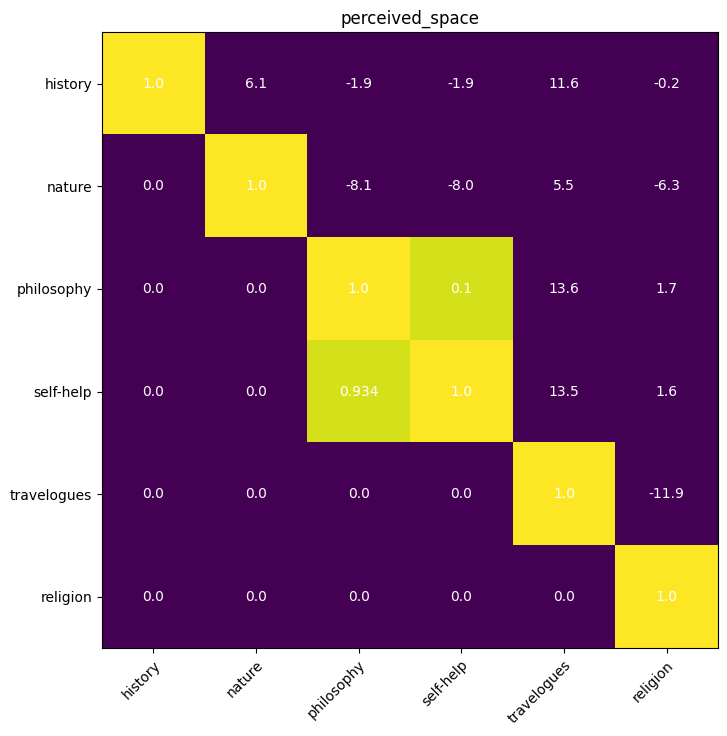

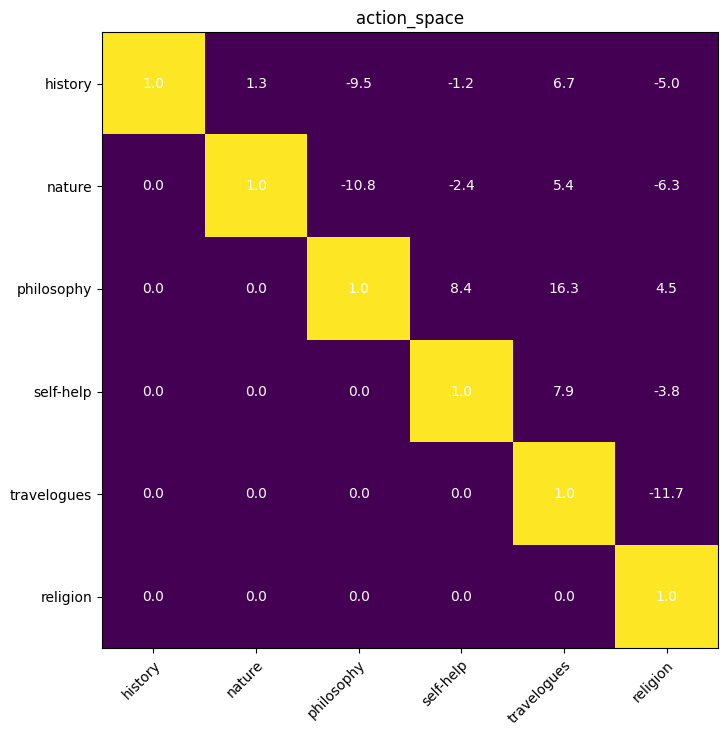

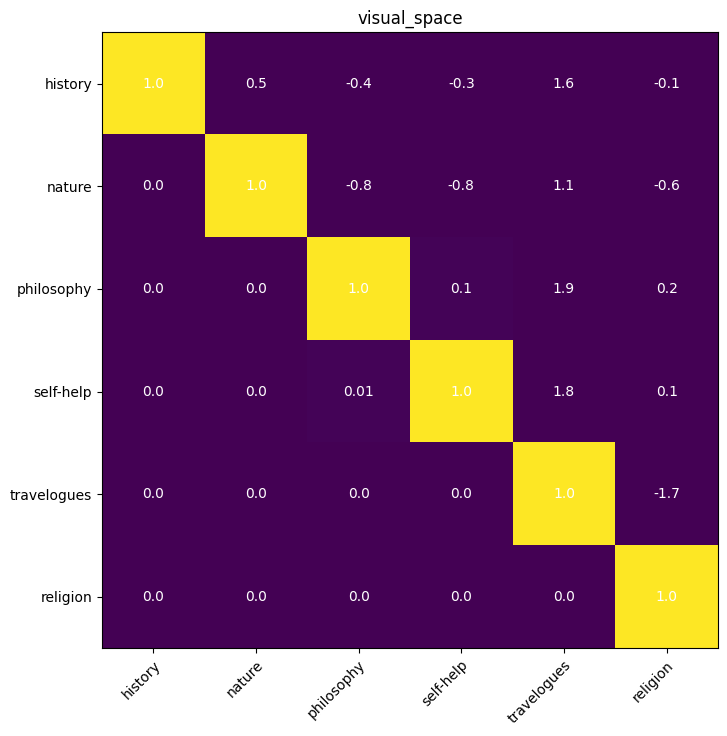

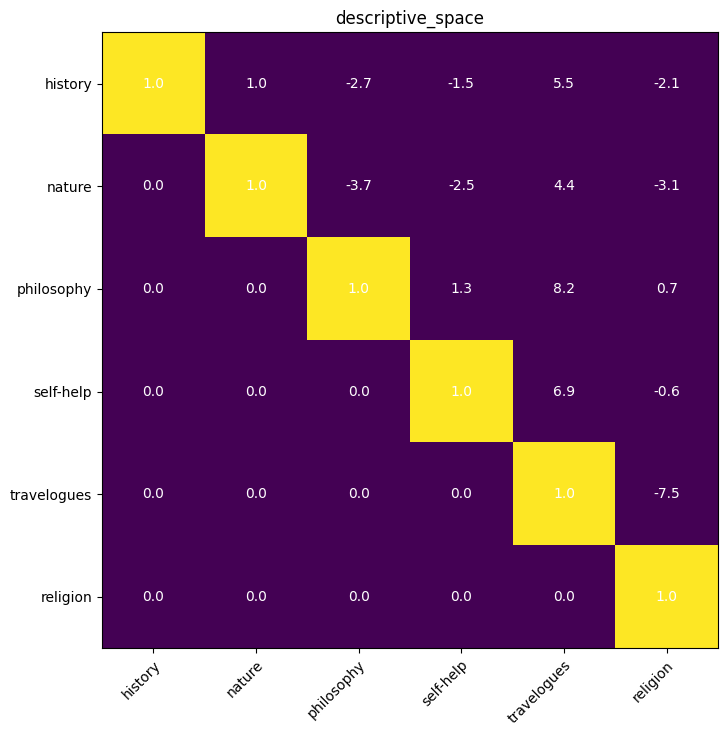

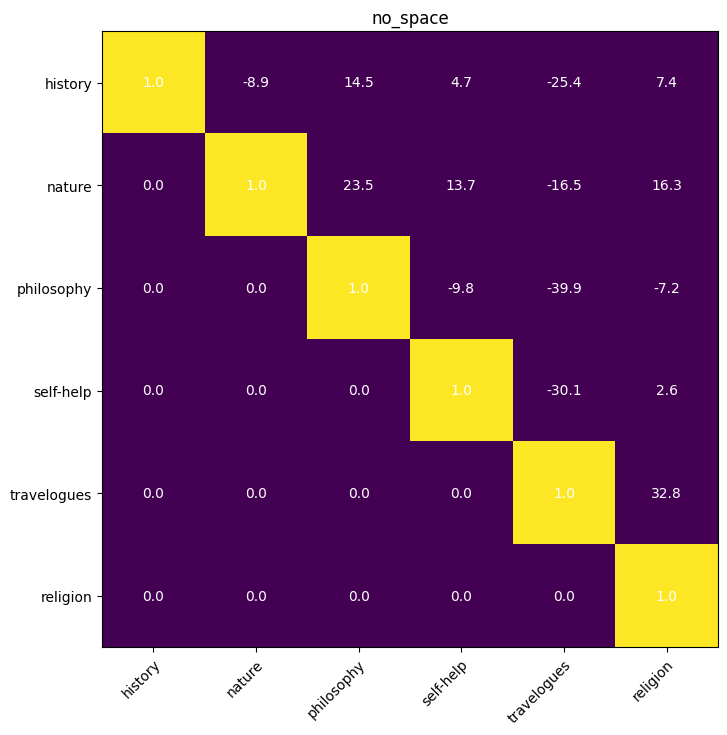

In [22]:
sns.reset_orig()

for space_type in SPACE_TYPES: 
    plot_p_values_heatmap(res, genres, space_type)